# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 



In [ ]:
import numpy as np
import torch
import torchvision
import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor 
from PIL import Image
from tqdm.auto import tqdm
import os
from torchvision import transforms
from os.path import isfile, join
import PIL

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip
!unzip -q dataset.zip

--2021-11-19 18:52:49--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/33l8lp62rmvtx40/dataset.zip [following]
--2021-11-19 18:52:49--  https://www.dropbox.com/s/raw/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc51d732db39e87837481d445c93.dl.dropboxusercontent.com/cd/0/inline/BaQm1YmxgCkggW1i3GO867LUIT-rPgX2DqsbZfPAF3gdSZodrDcfomkzQMmo2wgFG9kE596quo8p0i0SF-4dpilg05SFfLwCb3epNUVkLyFdJMyw0-anda4YHP0_db6Q05rx4ryRX3SMfw7eIHG02_JV/file# [following]
--2021-11-19 18:52:50--  https://uc51d732db39e87837481d445c93.dl.dropboxusercontent.com/cd/0/inline/BaQm1YmxgCkggW1i3GO867LUIT-rPgX2DqsbZfPAF3gdSZodrDcfomkzQMmo2wgFG9kE596quo8p0i0SF-4dpilg05

### Подготовка данных

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = os.path.expanduser(data_dir)
        self.transform = transform
        (self.data_path, self.labels) = ([], [])

        def load_images(path: str):

            images_dir = [join(path, f) for f in os.listdir(path)
                          if isfile(join(path, f))]
            images_dir.sort()

            return images_dir

        for i in range(200):
            if i < 10: 
                self.data_path += load_images(self.data_dir + "/class_00" + '{}'.format(i))
                self.labels += ([i]*len(os.listdir(self.data_dir + "/class_00" + '{}'.format(i))))
            if 9 < i < 100: 
                self.data_path += load_images(self.data_dir + "/class_0" + '{}'.format(i))
                self.labels += ([i]*len(os.listdir(self.data_dir + "/class_0" + '{}'.format(i))))
            if i > 99:
                self.data_path += load_images(self.data_dir + "/class_" + '{}'.format(i))
                self.labels += ([i]*len(os.listdir(self.data_dir + "/class_" + '{}'.format(i))))
        pass
    
    def __getitem__(self, idx):
        img = Image.open(self.data_path[idx]).convert("RGB") #Часть картинок чб
        target = self.labels[idx]

        if self.transform is not None:
            img = self.transform(img)
        return (img, target)
        pass
    
    def __len__(self):
        return len(self.data_path)
        pass

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(4096, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 200),
)

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((-0.0395, -0.1039, -0.2049), (0.4604, 0.4530, 0.4523))
    ]
)
val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((-0.0395, -0.1039, -0.2049), (0.4604, 0.4530, 0.4523))
    ]
)

train_dataset = MyDataset("dataset/dataset/train", transform=train_transform)
val_dataset = MyDataset("dataset/dataset/val", transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=50, shuffle=True)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Вспомогательные функции, реализация модели

In [ ]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.train()
    total_pred = torch.Tensor()
    total_labels = torch.Tensor()
    total_loss = 0

    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for _, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        y_pred = model(images)
        loss = criterion(y_pred, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        total_pred = torch.cat([total_pred, torch.argmax(y_pred.cpu(), dim=1)], dim=0)
        total_labels = torch.cat([total_labels, labels.cpu()], dim=0)
    total_accuracy = round(accuracy_score(total_pred, total_labels), 4)

    return round(total_loss, 4), total_accuracy

def predict(model, val_dataloder, criterion, device="cuda:0"):
    model.eval()

    # PREDICT FOR EVERY ELEMENT OF THE VAL DATALOADER AND RETURN CORRESPONDING LISTS
    losses = []
    true_classes = torch.Tensor()
    predicted_classes = torch.Tensor()
    with torch.no_grad():
        pbar = tqdm(enumerate(val_dataloder), total=len(val_dataloder))
        for _, (images, labels) in pbar:
            images = images.to(device)
            labels = labels.to(device)
            y_pred = model.to(device)(images)
            loss = criterion(y_pred, labels) 
            losses.append(loss.item())
            predicted_classes = torch.cat([predicted_classes, torch.argmax(y_pred.cpu(), dim=1)], dim=0)
            true_classes = torch.cat([true_classes, labels.cpu()], dim=0)

    return losses, predicted_classes.tolist(), true_classes.tolist()


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device="cuda:0", n_epochs=10):
    model.to(device)
    losses_list = []
    accuracies_list = []
    epoch_list = [i for i in range(n_epochs)]
    for epoch in range(n_epochs):
        loss, accuracy = train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0")
        scheduler.step()
        losses_list.append(loss)
        accuracies_list.append(accuracy)
        print(f"Epoch: {epoch}, loss: {loss}, accuracy: {accuracy}")
    plt.plot(epoch_list,accuracies_list)  
    plt.legend()
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.title("Accuracy train")
    plt.show()

    pass

### Обучение модели, запуски экспериментов

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.07, momentum=0.3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 
n_epochs = 15
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Простой тест на проверку правильности написанного кода

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

  0%|          | 0/200 [00:00<?, ?it/s]

tests passed


### Нужно попробовать в оптимейзере заменить lr в интервале 0.08 – 0.15 и сравнить. Можно поменять моментум. Число эпох в интервале 5 – 10.

Запустить обучение можно в ячейке ниже.

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, loss: 8857.3296, accuracy: 0.085


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 1, loss: 7589.3323, accuracy: 0.1632


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 2, loss: 7133.4827, accuracy: 0.2005


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 3, loss: 6864.8805, accuracy: 0.2239


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 4, loss: 6660.7302, accuracy: 0.241


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 5, loss: 6496.223, accuracy: 0.2547


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 6, loss: 6349.0223, accuracy: 0.2686


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 7, loss: 6244.1055, accuracy: 0.2782


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 8, loss: 6106.8065, accuracy: 0.291


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 9, loss: 6023.1223, accuracy: 0.2965


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 10, loss: 5937.5234, accuracy: 0.3046


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 11, loss: 5844.2349, accuracy: 0.3127


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 12, loss: 5788.0583, accuracy: 0.3189


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 13, loss: 5726.8921, accuracy: 0.3243


  0%|          | 0/2000 [00:00<?, ?it/s]

No handles with labels found to put in legend.


Epoch: 14, loss: 5661.6782, accuracy: 0.3298


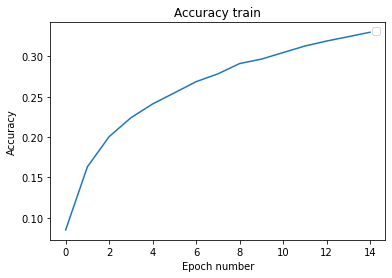

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, n_epochs)

### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5 * accuracy / 0.44)))

  0%|          | 0/200 [00:00<?, ?it/s]

Оценка за это задание составит 3.8670454545454547 баллов


In [ ]:
accuracy

0.3403

### Отчёт об экспериментах 

Данные были нормализованы. 

Пеовой попыткой было реализовать сеть состоящую только из последовательности свёрточный слой -> нелинейность -> pooling. Однако в таком случае сеть очень быстро переобучается, не смотря на попытки использовать аугментацию (       RandomColorJitter(), RandomHorizontalFlip(p=0.5), RandomAdjustSharpness(sharpness_factor=2) и др.,для расширения тренировочной выборки. На тренеровочной выборке accuracy составляла 0.61, в то время как на тестовой 0.11. Былв выбрана другая архитектура (за основу взялась сеть для классификации с семинара 3). В качестве регуляризации был использован дропаут, от аугментации отказалась, т.к. она сильно уменьшала скорость обучения. 

Осущаествлялся побор размера батчей (64 – 250).
Далее осуществлялся подбор гиперпараметров. Learning rate (подбирался в пределах 0.1 - 0.001) и momentum (0.2 - 0.9) для оптимайзера. Также подбирался гиперпараметр гамма для scheduler (0.1-0.9). В условиях небольшого числа эпох, оптимум гаммы 0.9).
        